# Задача декодировки изображений



[Дана выборка](data/regression.zip)

Выборка состоит из трех обзектов: X_train, Y_train, X_test

Y_train - изображение (пиксель кодируется черно-белой компонентой изображения), X_train - признаки, соответствующие этому изображению. (элемент X[i,j] соответствует набору признаков для пикселя Y[i,j]).

Требуется:

1. Провести отбор наиболее значимых признаков и построить регрессию X->Y
2. Проинтерпетировать признаки (каждый признак является функцией, возможно нелинейной, от значения пикселя)
3. Получить изображение по X_test (оцениваться будет качество полученного изображения. Ожидается, что регрессия на X_train, Y_train даст R^2>0.85).


In [4]:
magic_const= 35

In [5]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import statsmodels.formula.api as smf
X = np.load('regression_x_train.npy')
y = np.load('regression_y_train.npy')

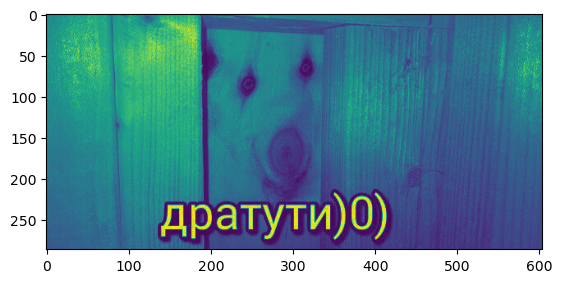

In [6]:
fig, ax = plt.subplots()

ax.imshow(y)
plt.show()

In [7]:
#cмотрим на признаки
res = []
for i in range(magic_const):
    feat, counter = np.unique(X[:,:,i], return_counts=True)
    res.append(counter)
    print(feat[0], counter)
        
print(res)

0.4967141530112327 [164397   8347]
-0.13826430117118466 [89102 83642]
0.6476885381006925 [91989 80755]
1.5230298564080254 [8347    1    1 ...    1    1    1]
-0.23415337472333597 [8347    1    1 ...    1    1    1]
-0.07024108708475416 [164397   8347]
0.47376384465221744 [89102 83642]
0.23023041874587263 [91989 80755]
-0.14084231578048562 [8347    1    1 ...    1    1    1]
0.1627680130757894 [8347    1    1 ...    1    1    1]
5.447335223145896 [164397   8347]
14.85883488891553 [164397   8347]
28.87405402738814 [164397   8347]
962.8718863692098 [164397   8347]
36.13914940471159 [89102 83642]
17.174595632318848 [89102 83642]
91.76644248291785 [89102 83642]
87.47657112101957 [89102 83642]
10.612537798017986 [91989 80755]
61.46424059746372 [91989 80755]
180.99567815468586 [91989 80755]
76.60516102097486 [91989 80755]
3.0080508384700395 [8347    1    1 ...    1    1    1]
62.62235226566029 [8347    1    1 ...    1    1    1]
45.448239581260914 [8347    1    1 ...    1    1    1]
64.481856

Потом выкинем последние 5 признаков, так как они имеют 1 уникальное значение, а значит не помогают делить выборку, не несут информации.

In [8]:
X.shape[2]

35

Давайте прогоним корреляции Пирсона

In [9]:
res = []
for i in range(magic_const):
    tmp = scipy.stats.pearsonr(X[:,:,i].flatten(), y.flatten()).statistic
    res.append(tmp)
    print(tmp)

    

-0.431958553730036
-0.5877302906563922
0.7743356258698562
0.21103454795626195
0.5232021586479911
-0.43195855373003594
-0.5877302906563922
0.7743356258698562
0.21103454795626175
0.523202158647991
-0.431958553730036
-0.43195855373003605
-0.431958553730036
-0.43195855373003605
-0.5877302906563922
-0.587730290656392
-0.587730290656392
-0.587730290656392
0.7743356258698563
0.7743356258698562
0.7743356258698562
0.7743356258698563
0.001448043940122705
0.0014480439401226841
0.0014480439401228784
0.0014480439401226772
0.33366532531669924
0.3336653253166991
0.33366532531669924
0.33366532531669924
nan
nan
nan
nan
nan


D:\AnacondaPython\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Итого у нас 7 разных видов корреляции. Значит, дублирующиеся признаки можно пока удалить. Скачаем тест

In [10]:
test = np.load('regression_x_test.npy')

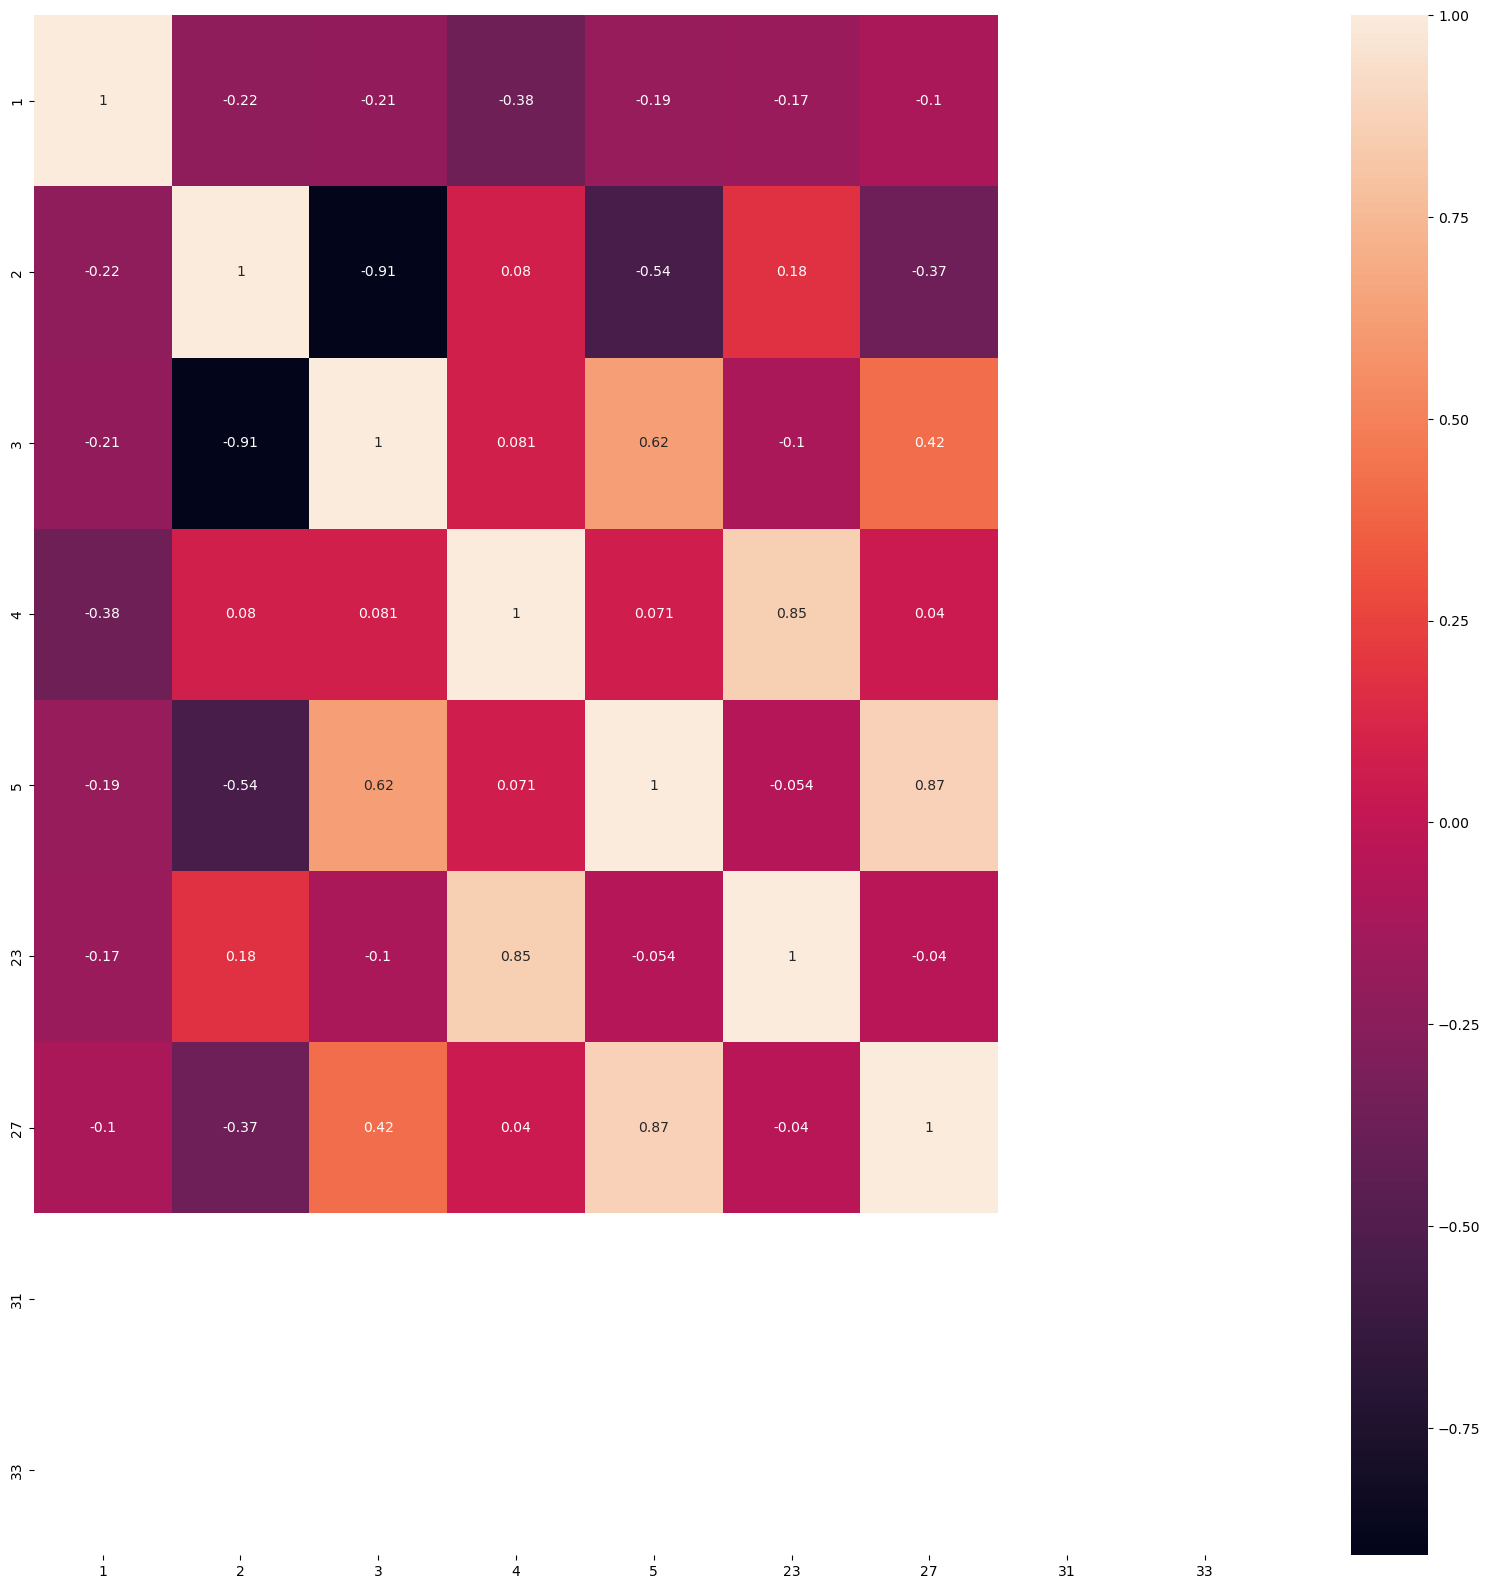

In [11]:
X = np.load('regression_x_train.npy')
y = np.load('regression_y_train.npy')
X = X.reshape(-1, 35)
X = pd.DataFrame(X, columns = [i for i in range(1, magic_const+1)])
 
X = X[[1, 2, 3, 4, 5, 23, 27, 31, 33]]
plt.figure(figsize=(20, 20))
_ = sns.heatmap(X.corr(), annot=True)

Сделаем остальные решейпы для запихивания в датафрейм. Заодно запустим обучение модели (fit)
Пары признаков 5 и 27, 4 и 23 - взаимо зависимы - их удаляем. (в смысле 27 и 23)

In [12]:
y = y.reshape(-1)

y = pd.DataFrame({'label': y})


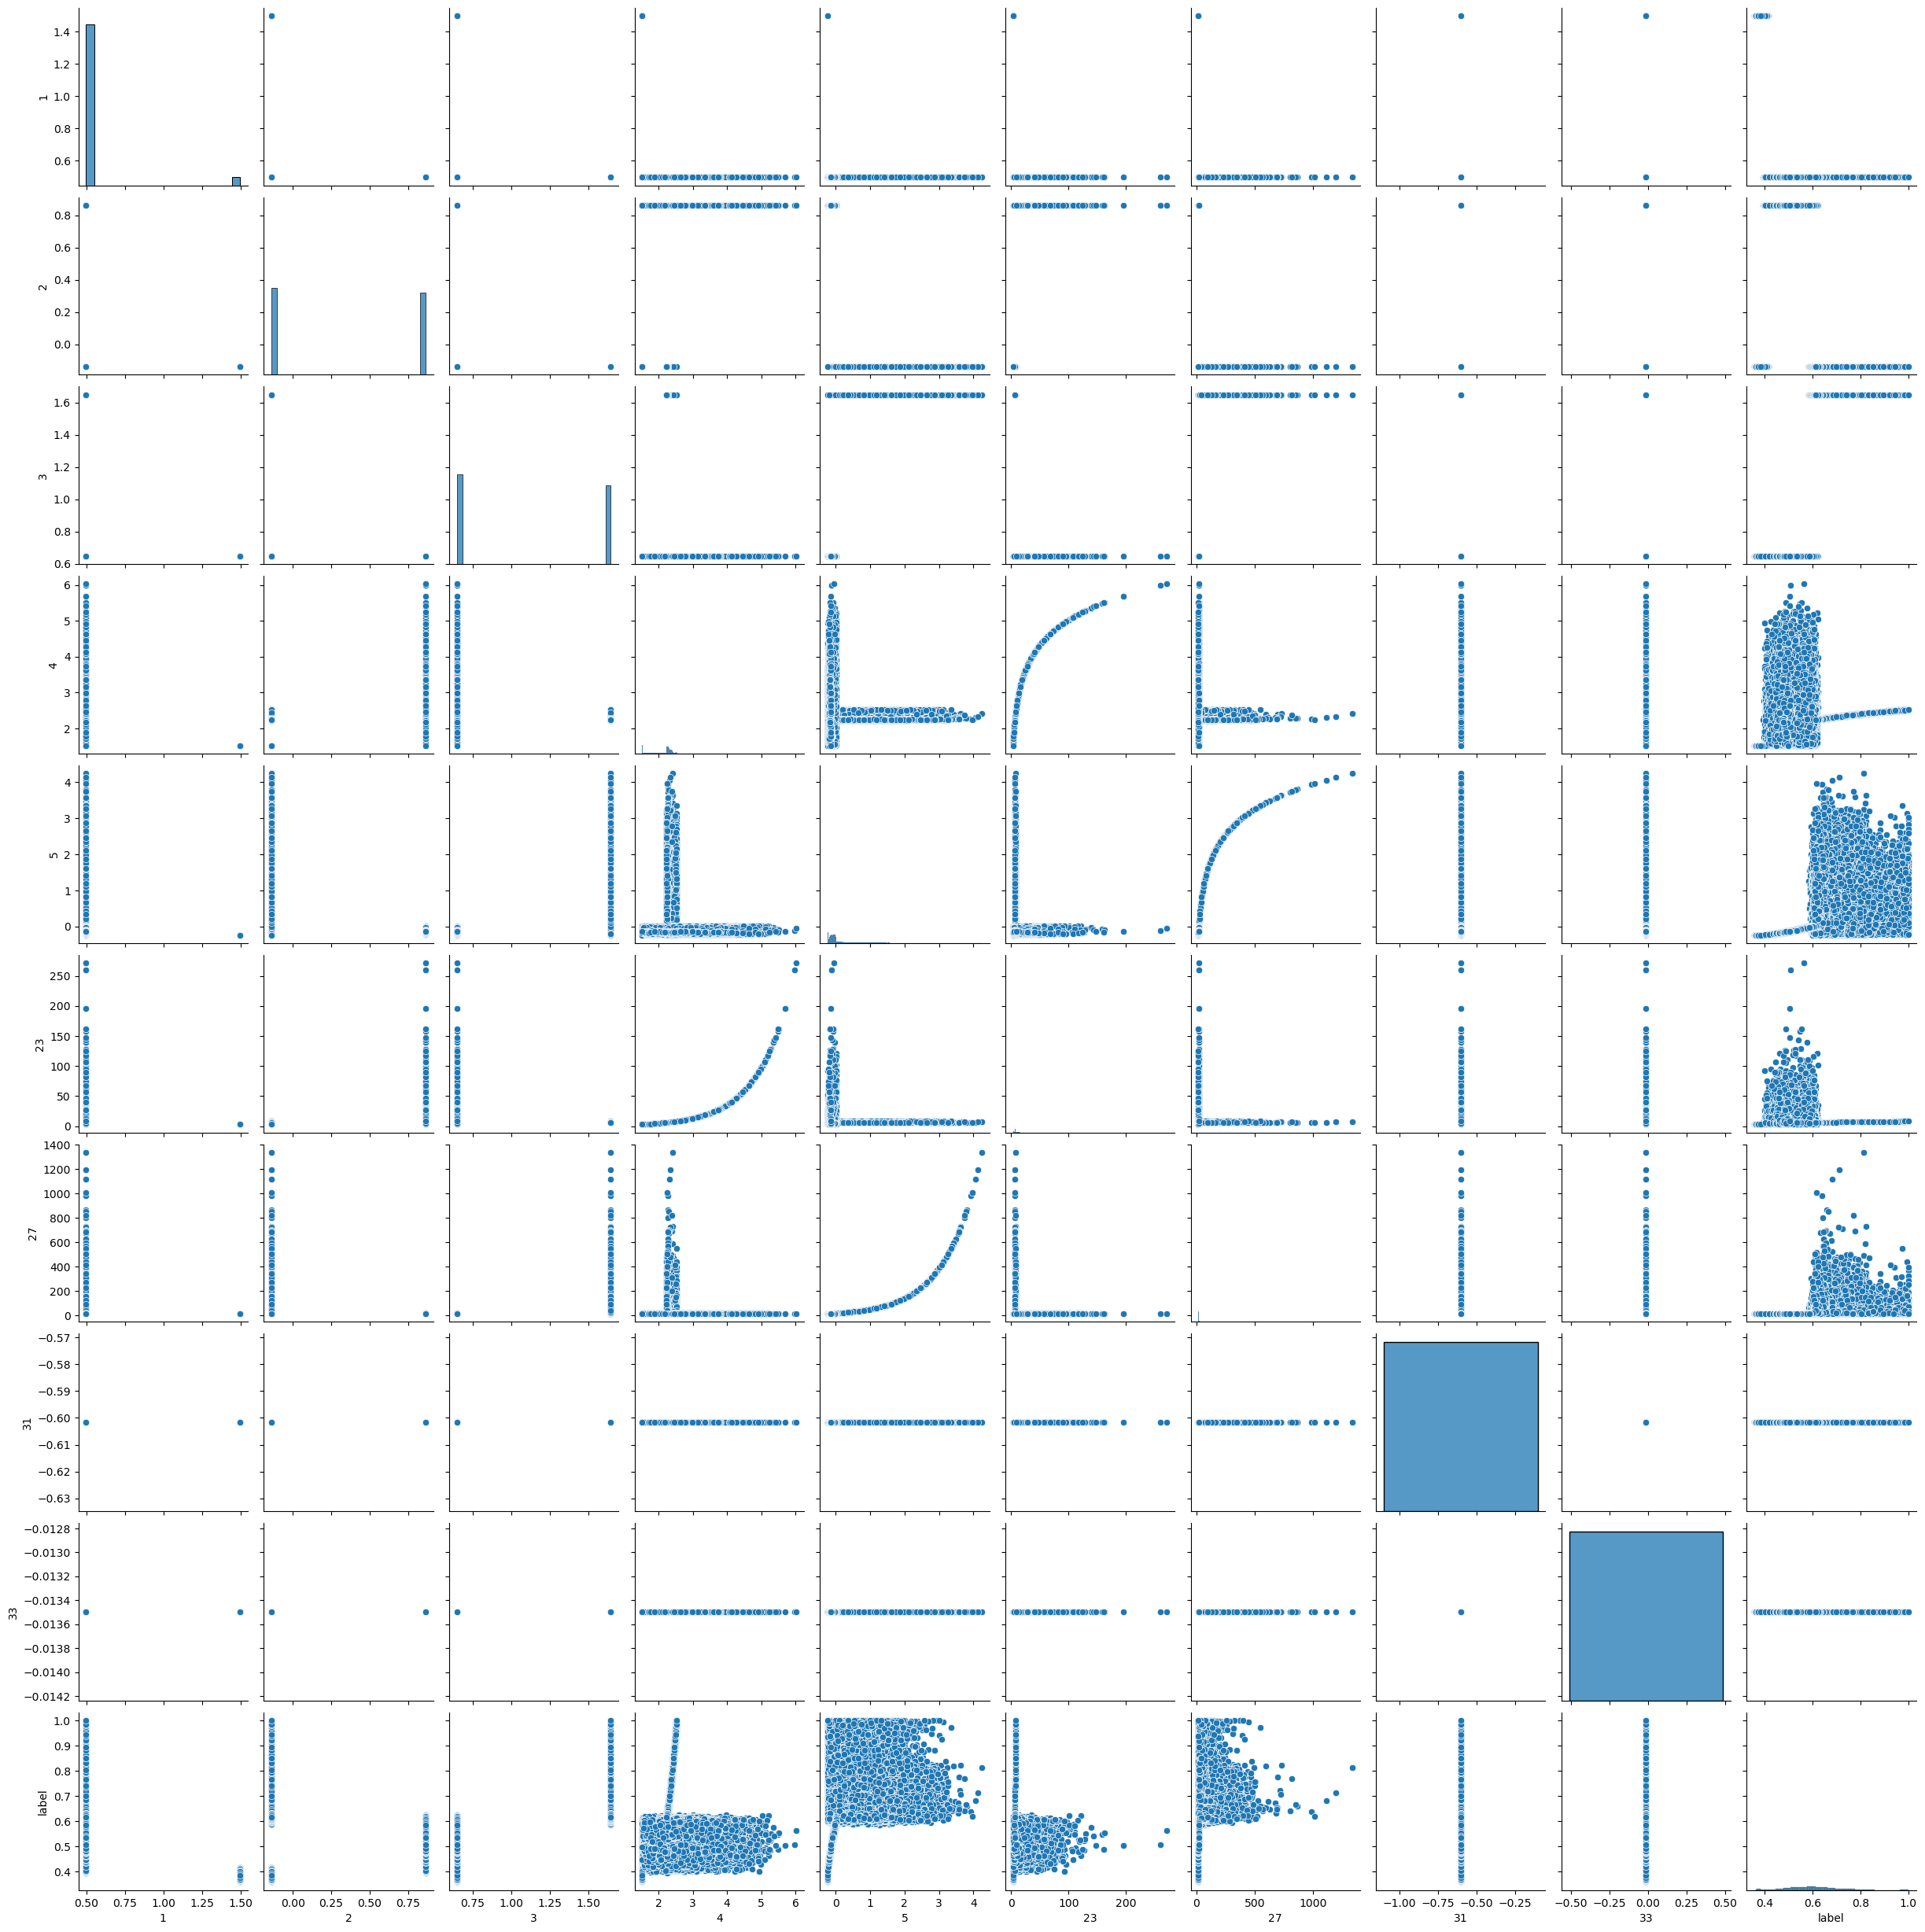

In [13]:
_ = sns.pairplot(pd.concat((X, y), axis=1))

Признаки 31 и 33 выглядят странно, поэтому их тоже стоит удалить. Но повременим.

In [14]:

X1 = X[[1, 2, 3, 4, 5, 31, 33]]
X1.columns
X1 = X1.rename(columns = {i: f'col{i}' for i in range(1, 34)})
print(X1.columns)

Index(['col1', 'col2', 'col3', 'col4', 'col5', 'col31', 'col33'], dtype='object')


Пора обучать модель

In [15]:

model_new = smf.ols('label ~ 1 + 2 + 3 + 4 +5 +31 +33', data=pd.concat((X1, y), axis=1)).fit()
model_new.summary()

PatsyError: numbers besides '0' and '1' are only allowed with **
    label ~ 1 + 2 + 3 + 4 +5 +31 +33
                ^

Цифры пихать нельзя, поэтому переименуем

In [16]:
model_new = smf.ols('label ~ col1 + col2 + col3 + col4 +col5 +col31 +col33', data=pd.concat((X1, y), axis=1)).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                 6.080e+04
Date:                Wed, 17 May 2023   Prob (F-statistic):               0.00
Time:                        01:40:23   Log-Likelihood:             2.2474e+05
No. Observations:              172744   AIC:                        -4.495e+05
Df Residuals:                  172737   BIC:                        -4.494e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.278e+09   2.61e+09      0.490      0.624   -3.83e+09    6.39e+09
col1        2.825e+09   7.79e+09      0.362      0.717   -1.25e+10    1.81e+10
col2        2.825e+09   7.79e+09      0.362      0.717   -1.25e+10    1.81e+10
col3        2.825e+09   7.79e+09      0.362      0.717   -1.25e+10    1.81e+10
col4           0.0142      0.000     37.907      0.000       0.014       0.015
col5           0.0087      0.000     22.774      0.000       0.008       0.009
col31       1.155e+10   2.47e+10      0.468      0.640   -3.69e+10       6e+10
col33      -3.841e+08   7.22e+08     -0.532      0.594    -1.8e+09    1.03e+09
==============================================================================
Omnibus:                    40645.541   Durbin-Watson:                   0.623
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121361.164
Skew:                           1.223   Prob(JB):                         0.00
Kurtosis:                       6.298   Cond. No.                     1.90e+29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.04e-53. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

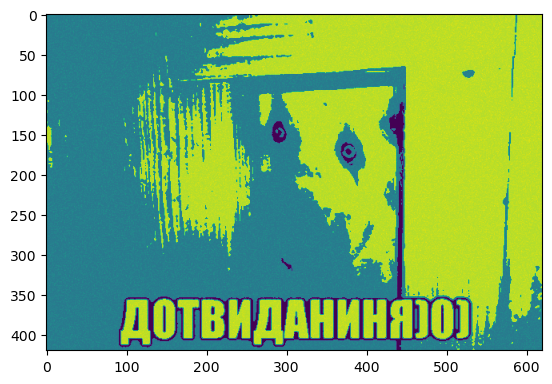

In [22]:
X = np.load('regression_x_train.npy')
Y = np.load('regression_y_train.npy')
X_test = np.load('regression_x_test.npy')
test = np.load('regression_x_test.npy')
test = test.reshape(-1, 35)
test = pd.DataFrame(test, columns = [i for i in range(1, magic_const+1)])

pred = model_new.predict(test.rename(columns ={i: f'col{i}' for i in range(1, 34)}))
test_Y = np.reshape(pred.values, (-1, X_test.shape[1]))

plt.imshow(test_Y)
plt.show()

In [23]:
X = np.load('regression_x_train.npy')
X = X.reshape(-1, 35)
X = pd.DataFrame(X, columns = [i for i in range(1, magic_const+1)])
X1 = X[[1, 2, 3, 4, 5,31,33]]
X1.columns
X1 = X1.rename(columns = {i: f'col{i}' for i in range(1,34)})
print(X1.columns)

Index(['col1', 'col2', 'col3', 'col4', 'col5', 'col31', 'col33'], dtype='object')


In [24]:
model_new = smf.ols('label ~ col1 * col2 + col3 * col4 +col5 + col31*col33', data=pd.concat((X1, y), axis=1)).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 2.487e+05
Date:                Wed, 17 May 2023   Prob (F-statistic):               0.00
Time:                        01:42:05   Log-Likelihood:             3.3442e+05
No. Observations:              172744   AIC:                        -6.688e+05
Df Residuals:                  172736   BIC:                        -6.687e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.387e+08   1.69e+09     -0.082      0.935   -3.45e+09    3.17e+09
col1         4.404e+08   4.84e+09      0.091      0.927   -9.04e+09    9.92e+09
col2        -2.136e+09   4.75e+09     -0.449      0.653   -1.15e+10    7.18e+09
col1:col2    4.057e+09   7.66e+09      0.530      0.596   -1.09e+10    1.91e+10
col3        -1.205e+08   4.38e+09     -0.028      0.978   -8.71e+09    8.47e+09
col4           -0.7970      0.001   -644.797      0.000      -0.799      -0.795
col3:col4       1.2302      0.002    665.017      0.000       1.227       1.234
col5            0.0088      0.000     43.397      0.000       0.008       0.009
col31       -1.696e+08   1.37e+10     -0.012      0.990   -2.71e+10    2.67e+10
col33        9.637e+06   3.93e+08      0.024      0.980   -7.62e+08    7.81e+08
col31:col33 -3.273e+06   1.06e+08     -0.031      0.975   -2.11e+08    2.04e+08
==============================================================================
Omnibus:                    12961.334   Durbin-Watson:                   0.591
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20882.977
Skew:                          -0.584   Prob(JB):                         0.00
Kurtosis:                       4.239   Cond. No.                     3.48e+29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.27e-53. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

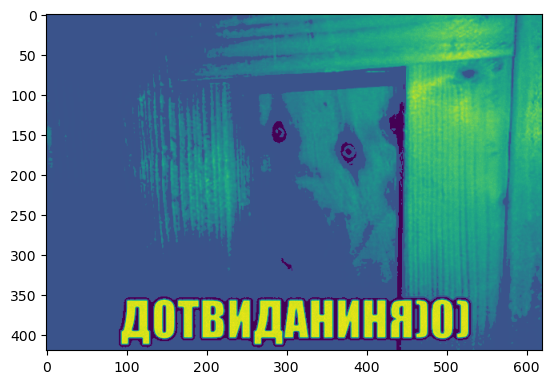

In [25]:
X = np.load('regression_x_train.npy')
Y = np.load('regression_y_train.npy')
test = np.load('regression_x_test.npy')
test = test.reshape(-1, 35)
test = pd.DataFrame(test, columns = [i for i in range(1, magic_const+1)])
pred = model_new.predict(test.rename(columns ={i: f'col{i}' for i in range(1, 34)}))
Y = np.reshape(pred.values, (-1, X_test.shape[1]))

plt.imshow(Y)
plt.show()

### Cпойлер

Совсем не тот результат, который ожидался. 


1) Признаки 31 и 33 неинформативны, так как состоят из константых значений. То есть их можно просто выкинуть
2) Модель суммы плоха и надо брать хитрую комбинацию попарных произведений label ~ col1 + col2 * col4 + col3 * col5

Без этих вещей получается результат выше

In [35]:
X = np.load('regression_x_train.npy')
X = X.reshape(-1, 35)
X = pd.DataFrame(X, columns = [i for i in range(1, magic_const+1)])
X1 = X[[1, 2, 3, 4, 5]]
X1.columns
X1 = X1.rename(columns = {i: f'col{i}' for i in range(1,6)})
print(X1.columns)

Index(['col1', 'col2', 'col3', 'col4', 'col5'], dtype='object')


In [38]:
model_new = smf.ols('label ~ col1+col2 / col3+col4/col5 ', data=pd.concat((X1, y), axis=1)).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                 7.335e+04
Date:                Wed, 17 May 2023   Prob (F-statistic):               0.00
Time:                        01:43:37   Log-Likelihood:             2.2505e+05
No. Observations:              172744   AIC:                        -4.501e+05
Df Residuals:                  172738   BIC:                        -4.500e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.986e+08   8.03e+08      0.247      0.805   -1.38e+09    1.77e+09
col1       -1.462e+08   5.91e+08     -0.247      0.805   -1.31e+09    1.01e+09
col2       -8.312e+08   3.36e+09     -0.247      0.805   -7.42e+09    5.76e+09
col2:col3   1.058e+09   4.28e+09      0.247      0.805   -7.33e+09    9.44e+09
col4           0.0147      0.000     39.161      0.000       0.014       0.015
col4:col5      0.0055      0.000     33.659      0.000       0.005       0.006
==============================================================================
Omnibus:                    41112.687   Durbin-Watson:                   0.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124435.975
Skew:                           1.232   Prob(JB):                         0.00
Kurtosis:                       6.349   Cond. No.                     9.30e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.41e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

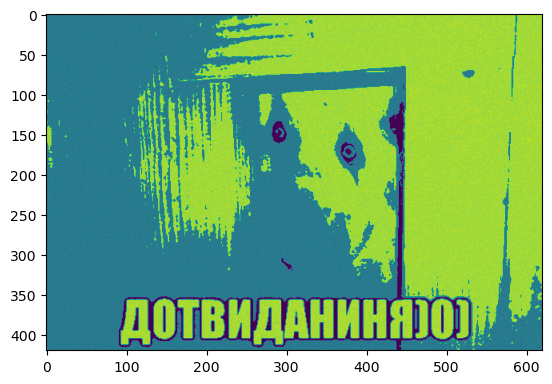

In [39]:
X = np.load('regression_x_train.npy')
Y = np.load('regression_y_train.npy')
test = np.load('regression_x_test.npy')
test = test.reshape(-1, 35)
test = pd.DataFrame(test, columns = [i for i in range(1, magic_const+1)])
pred = model_new.predict(test.rename(columns ={i: f'col{i}' for i in range(1, 6)}))
test_Y = np.reshape(pred.values, (-1, X_test.shape[1]))

plt.imshow(test_Y)
plt.show()

In [34]:

model_new = smf.ols('label ~ col1 + col2 * col4 + col3 * col5', data=pd.concat((X1, y), axis=1)).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.112e+06
Date:                Wed, 17 May 2023   Prob (F-statistic):               0.00
Time:                        01:42:31   Log-Likelihood:             5.4517e+05
No. Observations:              172744   AIC:                        -1.090e+06
Df Residuals:                  172736   BIC:                        -1.090e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.86e+08   3.98e+08      0.467      0.640   -5.94e+08    9.66e+08
col1       -9.273e+07   1.98e+08     -0.467      0.640   -4.82e+08    2.96e+08
col2       -9.273e+07   1.98e+08     -0.467      0.640   -4.82e+08    2.96e+08
col4           1.0599      0.000   2265.192      0.000       1.059       1.061
col2:col4     -1.2300      0.001  -2252.170      0.000      -1.231      -1.229
col3       -9.273e+07   1.98e+08     -0.467      0.640   -4.82e+08    2.96e+08
col5           1.2385      0.001   1351.673      0.000       1.237       1.240
col3:col5     -0.7516      0.001  -1344.941      0.000      -0.753      -0.751
==============================================================================
Omnibus:                    28541.544   Durbin-Watson:                   1.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97257.034
Skew:                           0.830   Prob(JB):                         0.00
Kurtosis:                       6.279   Cond. No.                     6.36e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.84e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

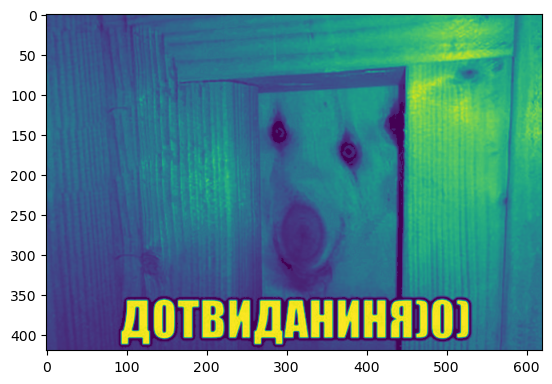

In [31]:
X = np.load('regression_x_train.npy')
Y = np.load('regression_y_train.npy')
test = np.load('regression_x_test.npy')
test = test.reshape(-1, 35)
test = pd.DataFrame(test, columns = [i for i in range(1, magic_const+1)])
pred = model_new.predict(test.rename(columns ={i: f'col{i}' for i in range(1, 6)}))
Y = np.reshape(pred.values, (-1, X_test.shape[1]))

plt.imshow(Y)
plt.show()

В результате анализа признаков и построения регрессии получен способ качественной обработки изображений при заданной кодировке. Другими словами, если у нас есть массив закодированных картинок со специальным форматом, то их можно декодировать достаточно простым и эффективным способом.

Дотвиданиня)0)